<a href="https://colab.research.google.com/github/arifazan/assignment/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.mixture import GaussianMixture
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
import matplotlib as mpl
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score


In [124]:
print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

def make_ellipses2(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

Automatically created module for IPython interactive environment


In [152]:
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse



In [125]:
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(URL,names=["sepal-length","sepal-width", "petal-length", "petal-width", "target"])

copy_df = df.copy()
del copy_df['sepal-width']
del copy_df['petal-width']
del copy_df['target']
copy_df = copy_df.rename(columns={'sepal-length': 'Sepal'})
copy_df = copy_df.rename(columns={'petal-length': 'Petal'})
target_df =  df.pop("target")

df_array = copy_df.to_numpy()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(df_array, target_df)))

X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=20,
                means_init=array([[5.04594595, 3.46486486, 1.46216216, 0.25945946],
       [5.91842105, 2.75789474, 4.25263158, 1.31578947],
       [6.59459459, 2.98378378, 5.51351351, 2.02432432]]),
                n_components=3, n_init=1, precisions_init=None, random_state=0,
                reg_covar=1e-06, tol=0.001, verbose=0, verbose_interval=10,
                warm_start=False, weights_init=None)
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=20,
                means_init=array([[5.04594595, 3.46486486, 1.46216216, 0.25945946],
       [5.91842105, 2.75789474, 4.25263158, 1.31578947],
       [6.59459459, 2.98378378, 5.51351351, 2.02432432]]),
                n_components=3, n_init=1, precisions_init=None, random_state=0,
                reg_covar=1e-06, tol=0.001, verbose=0, verbose_interval=10,
                warm_start=False, weights_init=None)


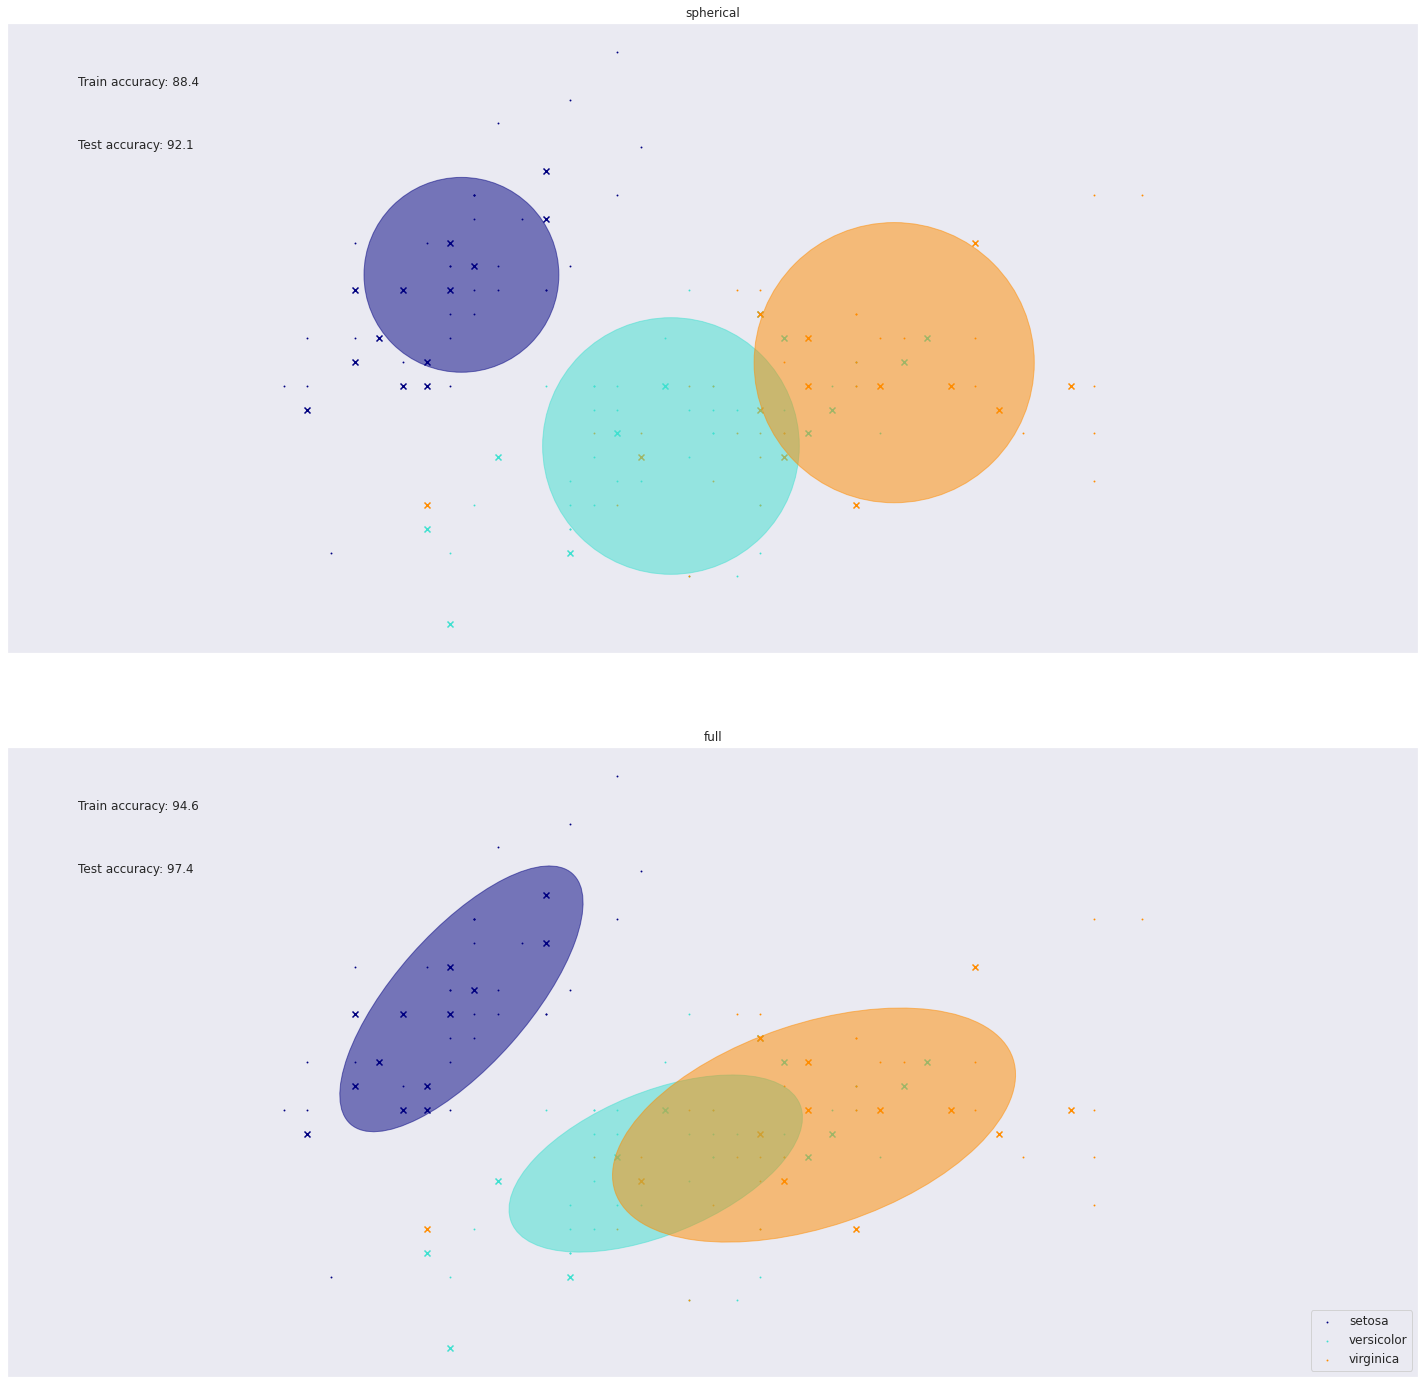

In [151]:
# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

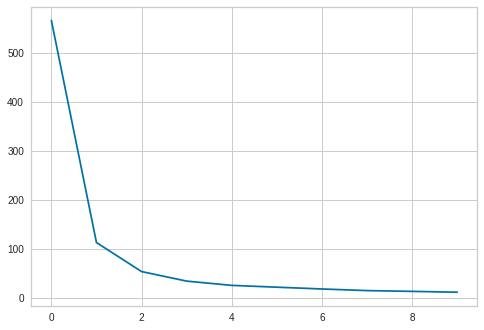

In [169]:
#Elbow Method
K = range(0,10)
plt.plot(K, calculate_WSS(df_array,10))

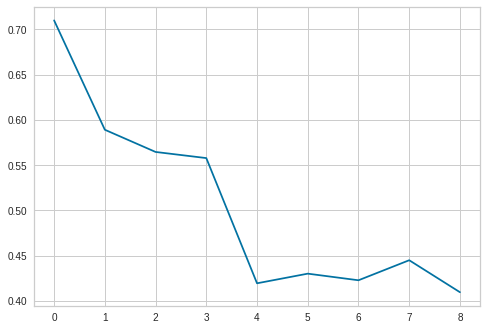

In [178]:
#Silhouette Method
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(df_array)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_array, labels, metric = 'euclidean'))

K = range(0,9)
plt.plot(K, sil)